# ACA centroiding with Dynamic Background subtraction#

### Goal ###

* Evaluate if dynamical background subtraction would prevent the 2017:090 BSH anomaly.

### Content ###
* __ObsID 18983__, observation prior to the bad maneuver and BSH 2017:090.

* __Slot 6__ with hot pixel tracked periodically.

* Compute centroids using various algorithms <code>(FlightBgd, DynamBgd_Median, DynamBgd_SigmaClip)</code>

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from astropy.table import Table
from kadi import events
from mica.archive import aca_l0
import Ska.engarchive.fetch as fetch
from astropy.io import ascii
from importlib import reload
from Chandra.Time import DateTime
from Ska.Matplotlib import plot_cxctime

In [2]:
# local imports:
import sys
sys.path.append("../py")
import classes
from classes import *
import sim_aca_l0 as siml0
import centroids as cntr
import myplot as mplt

In [3]:
def do_computations(slots, dwell, img_size, nframes, start=None, stop=None, bgd_kwargs={}):
    if start is None:
        start = dwell.start
    if stop is None:
        stop = dwell.stop
    rows_all = []
    for slot in slots:
        slot_data = aca_l0.get_slot_data(start, stop, slot=slot)
        print('Slot {}'.format(slot))
        for i, Bgd_Class in enumerate([FlightBgd, DynamBgd_Median, DynamBgd_SigmaClip]):
            bgd_object = Bgd_Class(**bgd_kwargs[i])
            #print(bgd_object.__class__.__name__)
            rows = cntr.centroids(slot, slot_data, img_size, bgd_object, nframes=nframes)
            for row in rows:
                row['mag'] = np.median(dat["aoacmag{}".format(slot)].vals)
                row['bgd_class_name'] = bgd_object.__class__.__name__
                if isinstance(bgd_object, (DynamBgd_Median, DynamBgd_SigmaClip)):
                    row['ndeque'] = bgd_kwargs[i]['ndeque']
                else:
                    row['ndeque'] = None
                rows_all.append(row)        
    t = Table(rows_all)
    return t


def plot_seqs(dat, slot, seqs):
    vals = []
    for i, seq in enumerate(seqs):
        vals.append((dat['aoacfct{}'.format(slot)].vals == seq) * (i + 1))
    return vals


def map_rowcol(t, nstart=None, nstop=None):

    ok1 = t_data_5['bgd_class_name'] == 'FlightBgd'
    ok2 = t_data_5['bgd_class_name'] == 'DynamBgd_Median'

    if nstart is None:
        nstart = 0
    if nstop is None:
        nstop = nstart + len(t_data_5[ok1][0]['row'][nstart:])

    alpha = np.linspace(0.05, 0.95,  nstop - nstart)

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.scatter(t[ok1][0]['col'][nstart:nstop], t[ok1][0]['row'][nstart:nstop],
                c=alpha, marker='o', linewidths=0, cmap='Blues')
    plt.title('FlightBgd')

    plt.subplot(1, 2, 2)
    plt.title('DynamBgd_Median')
    plt.scatter(t[ok2][0]['col'][nstart:nstop], t[ok2][0]['row'][nstart:nstop],
                c=alpha, marker='o', linewidths=0, cmap='Blues')

    axes = plt.gcf().axes
    for ax in axes:
        ax.set_aspect('equal')
        ax.set_xlim(0, 6)
        ax.set_ylim(0, 6)
        ax.set_xlabel('col')
        ax.set_ylabel('row')
        ax.grid(True)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
    return

__Computations__

In [4]:
# 18983, ACIS, bright star in slot 3,
# investigate improvement to centroids of stars in slots 6, 7
# in which ACA started tracking hot pixels
obsid = 18983
img_size = 6 # pixels
dwell = events.dwells.filter(obsid=obsid)[0]

In [5]:
msids = ["aoacfct{}".format(slot) for slot in range(8)] + \
        ["aoacmag{}".format(slot) for slot in range(8)]
dat = fetch.MSIDset(msids, start=dwell.start, stop=dwell.stop)

print('TRAK:')
print([dat[msid].vals.tolist().count('TRAK') for msid in msids[:8]])
print('RACQ:')
print([dat[msid].vals.tolist().count('RACQ') for msid in msids[:8]])
print('SRCH:')
print([dat[msid].vals.tolist().count('SRCH') for msid in msids[:8]])
print('MAG:')
print([np.median(dat[msid].vals) for msid in msids[8:]])

TRAK:
[5153, 5147, 5153, 5153, 5153, 5153, 5041, 5153]
RACQ:
[0, 6, 0, 0, 0, 0, 104, 0]
SRCH:
[0, 0, 0, 0, 0, 0, 8, 0]
MAG:
[7.0625, 7.125, 7.125, 7.1875, 9.5625, 8.25, 10.1875, 9.9375]


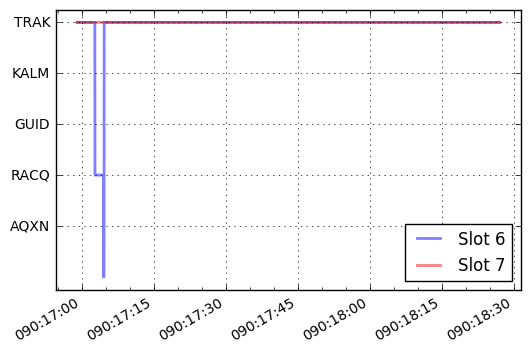

In [6]:
seqs = ['AQXN', 'RACQ', 'GUID', 'KALM', 'TRAK']

slot = 6
vals = plot_seqs(dat, slot, seqs)
plot_cxctime(dat['aoacfct{}'.format(slot)].times, np.sum(vals, axis=0),
             lw=2, alpha=0.5, color='b', label='Slot {}'.format(slot))
slot = 7
vals = plot_seqs(dat, slot, seqs)
plot_cxctime(dat['aoacfct{}'.format(slot)].times, np.sum(vals, axis=0),
            lw=2, alpha=0.5, color='r', label='Slot {}'.format(slot))
plt.yticks([1, 2, 3, 4, 5], seqs)
plt.grid()
plt.legend(loc='best')
plt.margins(0.05);

In [7]:
slots = [6, 3] # [Faint with hot pixel, bright]
bgdavg = None
nframes = None # use all frames

__Small__ number of stored pixel values

In [8]:
ndeque = 5
bgd_kwargs = [{}, {'img_size':img_size, 'bgdavg':bgdavg, 'ndeque':ndeque},
                  {'img_size':img_size, 'bgdavg':bgdavg, 'ndeque':ndeque}]

In [9]:
# Don't oversubtract background, in cntr
reload(cntr)
start = '2017:090:17:10:00'
t_data_5 = do_computations(slots, dwell, img_size, nframes=nframes, start=start, bgd_kwargs=bgd_kwargs)

Slot 6


../py/centroids.py:195: RuntimeWarning: invalid value encountered in double_scalars
  centroid = np.sum(flat[:-2] * num) / np.sum(flat[:-2]) # 0:6


Slot 3


### Plot residuals###

In [10]:
print(t_data_5['bgd_class_name', 'slot', 'mag'])
print()
print(t_data_5.colnames)

  bgd_class_name   slot   mag  
------------------ ---- -------
         FlightBgd    6 10.1875
   DynamBgd_Median    6 10.1875
DynamBgd_SigmaClip    6 10.1875
         FlightBgd    3  7.1875
   DynamBgd_Median    3  7.1875
DynamBgd_SigmaClip    3  7.1875

['bgd_class_name', 'bgdimg', 'col', 'col0', 'deque_dict', 'img', 'imgraw', 'mag', 'ndeque', 'row', 'row0', 'slot', 'time', 'yan', 'zan']


In [11]:
reload(mplt);

Intensity of color increases with time


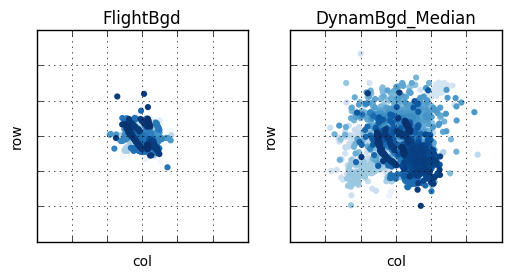

In [12]:
map_rowcol(t_data_5)
print('Intensity of color increases with time')

First instance of the hot pixel taking over the image window.


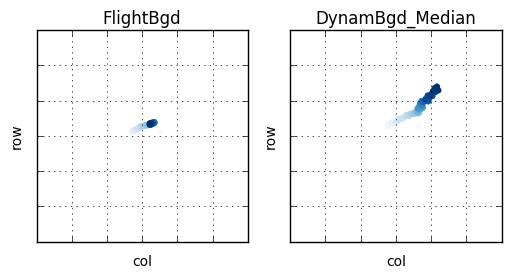

In [13]:
map_rowcol(t_data_5, nstart=310, nstop=390)
print('First instance of the hot pixel taking over the image window.')

First instance of slot 6 tracking the hot pixel.


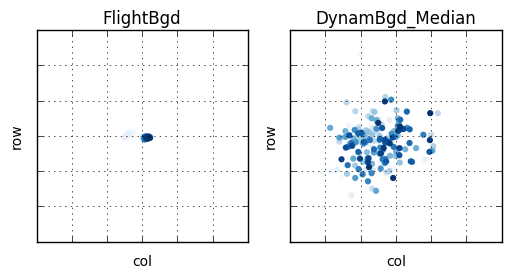

In [14]:
map_rowcol(t_data_5, nstart=430, nstop=600)
print('First instance of slot 6 tracking the hot pixel.')

First instance of recovery.


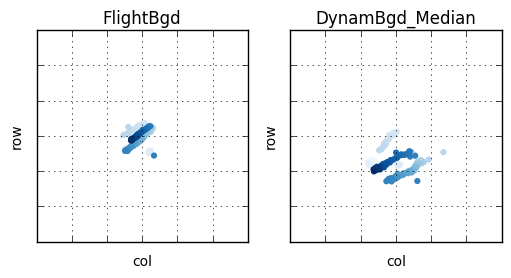

In [15]:
map_rowcol(t_data_5, nstart=640, nstop=800)
print('First instance of recovery.')

In [16]:
slot = 6

Format of the titles is 'frame #: imgrow0, imgcol0'
Plot imgraw from 147 to 154
Bgd Class: DynamBgd_Median, ndeque = 5

Hot pixel enters the image window for the first time.


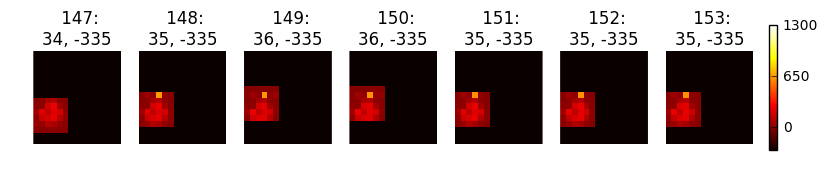

In [17]:
data = mplt.plot_images(t_data_5, n_start=147, n_stop=154, slot=slot,
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-300, vmax=1300, colname='imgraw')

print('\nHot pixel enters the image window for the first time.')

In [18]:
ok = t_data_5['bgd_class_name'] == 'FlightBgd'
print((t_data_5['time'][ok][1] - t_data_5['time'][ok][0])[:5]) # bright - faint

[ 0.  0.  0.  0.  0.]


Slot 6 - Slot 3
ndeque = 5
std computed between Time = 0 and the vertical line


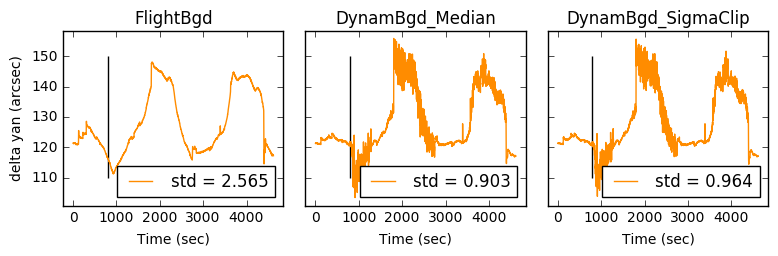

In [19]:
dt = 0. # shift in sec between time axes for faint and bright star
key = 'yan'
nstop = 390
mplt.plot_d_ang(6, 3, key, dt, t_data_5, nstop=nstop)
print("Slot 6 - Slot 3")
print("ndeque = 5")
print("std computed between Time = 0 and the vertical line")

axs = plt.gcf().axes
for ax in axs:
    ax.vlines([nstop * 2.05], 110, 150)

Slot 6 - Slot 3
ndeque = 5
std computed between the vertical lines


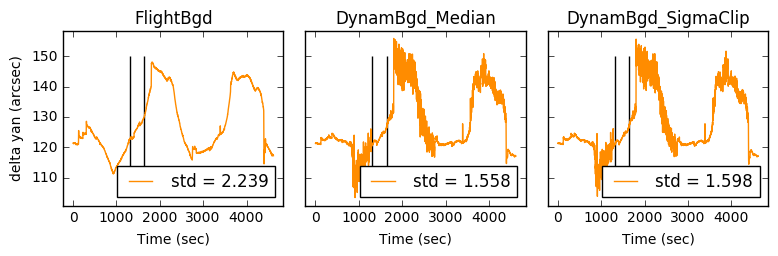

In [20]:
dt = 0. # shift in sec between time axes for faint and bright star
key = 'yan'
nstart = 640
nstop = 800
mplt.plot_d_ang(6, 3, key, dt, t_data_5, nstart=nstart, nstop=nstop)
print("Slot 6 - Slot 3")
print("ndeque = 5")
print("std computed between the vertical lines")

axs = plt.gcf().axes
for ax in axs:
    ax.vlines([nstart * 2.05, nstop * 2.05], 110, 150)

Slot 6 - Slot 3
ndeque = 5
std computed between the vertical lines


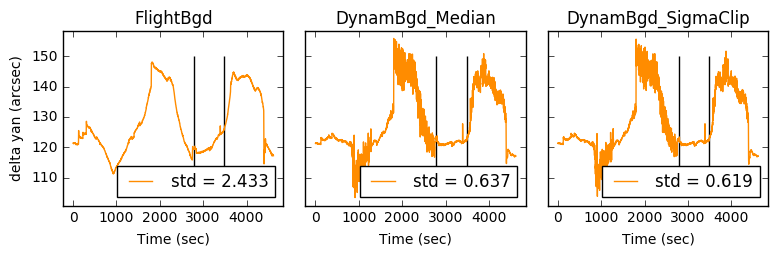

In [21]:
dt = 0. # shift in sec between time axes for faint and bright star
key = 'yan'
nstart = 1360
nstop = 1700
mplt.plot_d_ang(6, 3, key, dt, t_data_5, nstart=nstart, nstop=nstop)
print("Slot 6 - Slot 3")
print("ndeque = 5")
print("std computed between the vertical lines")

axs = plt.gcf().axes
for ax in axs:
    ax.vlines([nstart * 2.05, nstop * 2.05], 110, 150)

### Plot centroids###


Number of pixel samples, ndeque = 5


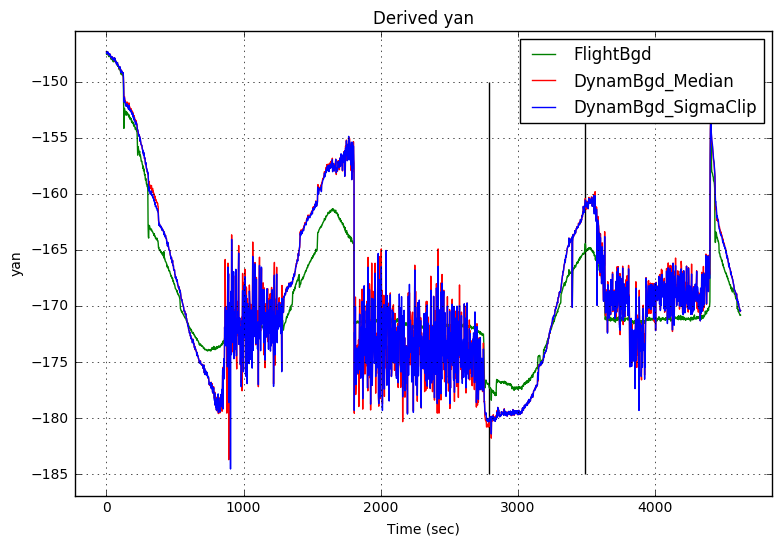

In [22]:
slot = slots[0] # tracking warm pixel
#mplt.plot_coords(slot, t_data_5, 'row') # computed 'row' coordinate (between 0 and 8)
mplt.plot_coords(slot, t_data_5, 'yan') # computed 'yan' coordinate
print()
print("Number of pixel samples, ndeque = {}".format(5))
nstart = 1360
nstop = 1700
plt.vlines([nstart * 2.05, nstop * 2.05], -185, -150);


Number of pixel samples, ndeque = 5


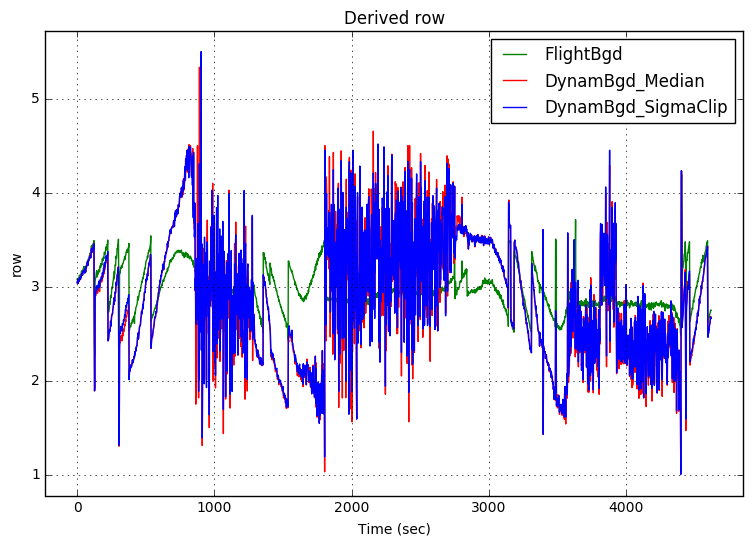

In [23]:
slot = slots[0] # tracking warm pixel
mplt.plot_coords(slot, t_data_5, 'row') # computed 'row' coordinate (between 0 and 8)
#mplt.plot_coords(slot, t_data_5, 'yan') # computed 'yan' coordinate
print()
print("Number of pixel samples, ndeque = {}".format(5));

### Plot derived background and star images, and hot pixels time history ###

* <span style="color:black;font-weight:bold">Black patch</span> - CCD region that will eventually be sampled due to the dither
* <span style="color:crimson;font-weight:bold">6x6 patches</span> - pixel region corresponding to background derived for a current frame (sampled edge pixels + average background value for pixels inside the edge)

In [24]:
slot = 6 # Slot tracking the hot pixel

In [25]:
reload(mplt);

Format of the titles is 'frame #: imgrow0, imgcol0'
Plot imgraw from 310 to 317
Bgd Class: DynamBgd_Median, ndeque = 5

Due to dither, star drifts away from the image window.
The hot pixel prevents the image window from tracking the star.


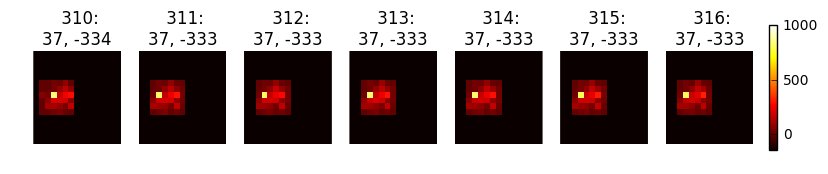

In [26]:
data = mplt.plot_images(t_data_5, n_start=310, n_stop=317, slot=slot,
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-150, vmax=1000, colname='imgraw')

print('\nDue to dither, star drifts away from the image window.')
print('The hot pixel prevents the image window from tracking the star.')

Format of the titles is 'frame #: imgrow0, imgcol0'
Plot imgraw from 383 to 390
Bgd Class: DynamBgd_Median, ndeque = 5

Due to dither, star drifts away from the image window.
The hot pixel prevents the image window from tracking the star.


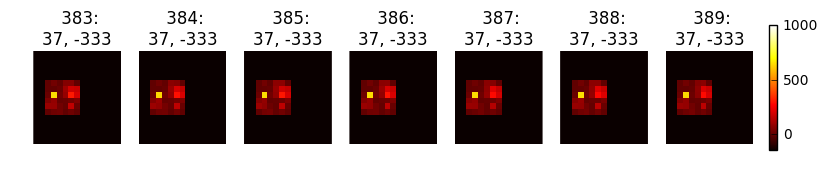

In [27]:
data = mplt.plot_images(t_data_5, n_start=383, n_stop=390, slot=slot,
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-150, vmax=1000, colname='imgraw')

print('\nDue to dither, star drifts away from the image window.')
print('The hot pixel prevents the image window from tracking the star.')

Format of the titles is 'frame #: imgrow0, imgcol0'
Plot bgdimg from 383 to 390
Bgd Class: DynamBgd_Median, ndeque = 5

Starlight gets included in the dynamic background.


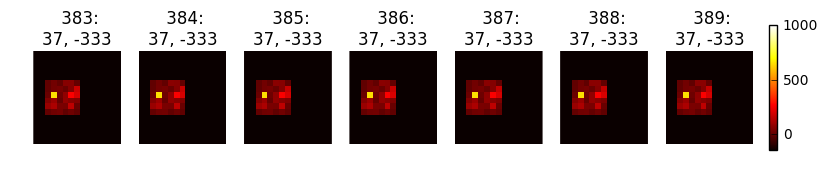

In [28]:
data = mplt.plot_images(t_data_5, n_start=383, n_stop=390, slot=slot,
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-150, vmax=1000, colname='bgdimg')

print('\nStarlight gets included in the dynamic background.')

Format of the titles is 'frame #: imgrow0, imgcol0'
Plot img from 383 to 390
Bgd Class: DynamBgd_Median, ndeque = 5

Dynamic background subtracted image resambles noise.


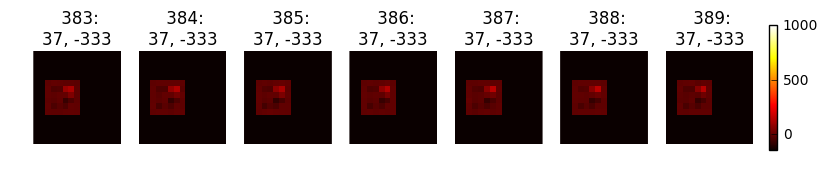

In [29]:
data = mplt.plot_images(t_data_5, n_start=383, n_stop=390, slot=slot,
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-150, vmax=1000, colname='img')

print('\nDynamic background subtracted image resambles noise.')

Format of the titles is 'frame #: imgrow0, imgcol0'
Plot img from 383 to 390
Bgd Class: FlightBgd, ndeque = None


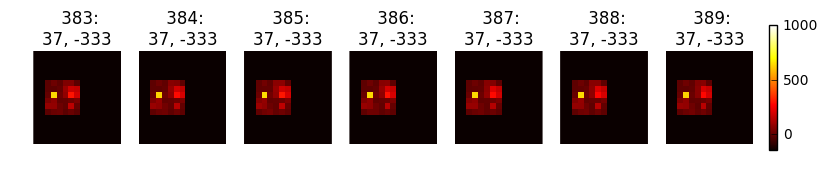

In [30]:
data = mplt.plot_images(t_data_5, n_start=383, n_stop=390, slot=slot,
                        img_size=img_size, bgd_class_name='FlightBgd',
                        vmin=-150, vmax=1000, colname='img')

__Recovery__

Format of the titles is 'frame #: imgrow0, imgcol0'
Plot imgraw from 625 to 632
Bgd Class: DynamBgd_Median, ndeque = 5


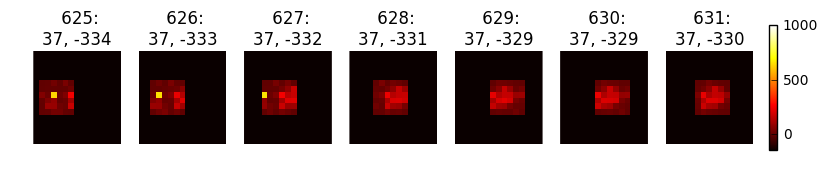

In [31]:
data = mplt.plot_images(t_data_5, n_start=625, n_stop=632, slot=slot,
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-150, vmax=1000, colname='imgraw')

Format of the titles is 'frame #: imgrow0, imgcol0'
Plot bgdimg from 625 to 632
Bgd Class: DynamBgd_Median, ndeque = 5


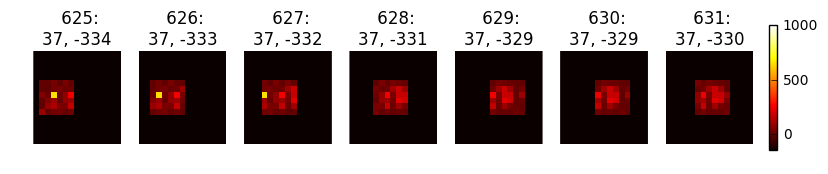

In [32]:
data = mplt.plot_images(t_data_5, n_start=625, n_stop=632, slot=slot,
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-150, vmax=1000, colname='bgdimg')

Format of the titles is 'frame #: imgrow0, imgcol0'
Plot img from 625 to 632
Bgd Class: DynamBgd_Median, ndeque = 5


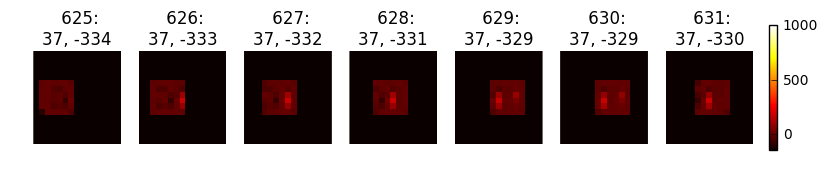

In [33]:
data = mplt.plot_images(t_data_5, n_start=625, n_stop=632, slot=slot,
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-150, vmax=1000, colname='img')

Format of the titles is 'frame #: imgrow0, imgcol0'
Plot img from 625 to 632
Bgd Class: FlightBgd, ndeque = None


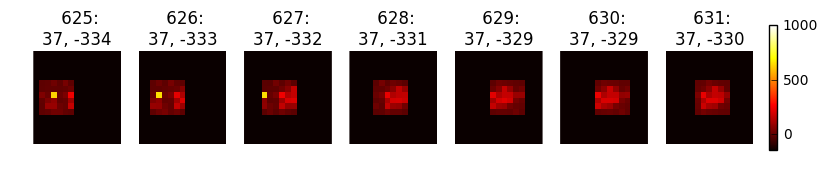

In [34]:
data = mplt.plot_images(t_data_5, n_start=625, n_stop=632, slot=slot,
                        img_size=img_size, bgd_class_name='FlightBgd',
                        vmin=-150, vmax=1000, colname='img')

__Hot pixel enters the image window for the 2nd time__

Format of the titles is 'frame #: imgrow0, imgcol0'
Plot imgraw from 683 to 690
Bgd Class: DynamBgd_Median, ndeque = 5


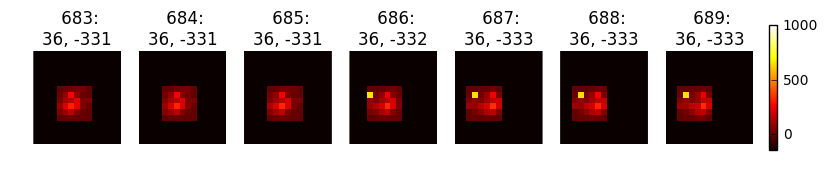

In [35]:
data = mplt.plot_images(t_data_5, n_start=683, n_stop=690, slot=slot,
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-150, vmax=1000, colname='imgraw')

Format of the titles is 'frame #: imgrow0, imgcol0'
Plot bgdimg from 683 to 690
Bgd Class: DynamBgd_Median, ndeque = 5


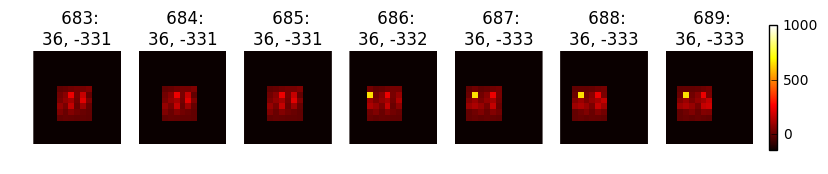

In [36]:
data = mplt.plot_images(t_data_5, n_start=683, n_stop=690, slot=slot,
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-150, vmax=1000, colname='bgdimg')

Format of the titles is 'frame #: imgrow0, imgcol0'
Plot img from 683 to 690
Bgd Class: DynamBgd_Median, ndeque = 5


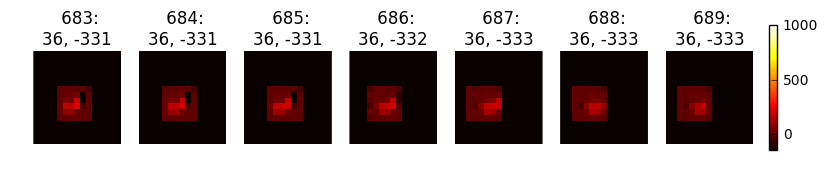

In [37]:
data = mplt.plot_images(t_data_5, n_start=683, n_stop=690, slot=slot,
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-150, vmax=1000, colname='img')

Format of the titles is 'frame #: imgrow0, imgcol0'
Plot img from 683 to 690
Bgd Class: FlightBgd, ndeque = None


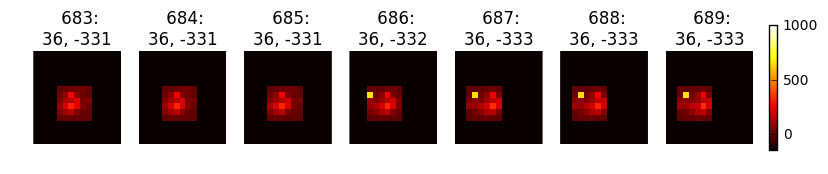

In [38]:
data = mplt.plot_images(t_data_5, n_start=683, n_stop=690, slot=slot,
                        img_size=img_size, bgd_class_name='FlightBgd',
                        vmin=-150, vmax=1000, colname='img')

### Plot time history of the hot pixel ###

ndeque = 5


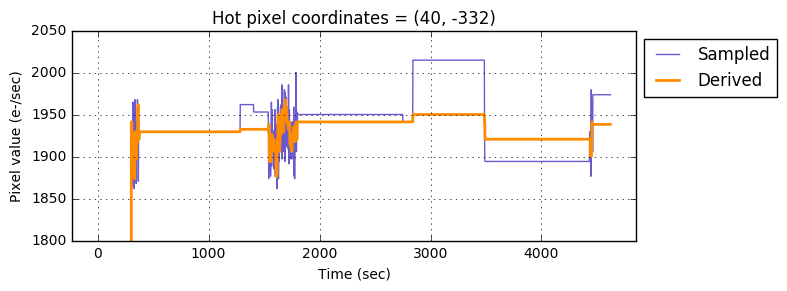

In [39]:
reload(mplt)
mplt.plot_px_history(t_data_5, [(40, -332)], slot=slot, bgd_class_name='DynamBgd_Median')
plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0))
print("ndeque = 5")
plt.ylim(1800, 2050);